### Regression Discontinuity Design with Spline

Regression discontinuity design (RDD) is a causal inference method used in economics, political science, and other fields to estimate the causal effect of a treatment or policy on an outcome variable. It is based on the idea that if a treatment or policy is assigned based on a threshold value of an assignment variable, the treatment and control groups should be similar in all respects except for the treatment itself. RDD can be used to estimate the effect of a treatment or policy when a randomized experiment is not feasible or ethical. The key assumption of RDD is that the assignment variable is a continuous variable and the treatment or policy is assigned based on a sharp threshold value of this variable.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
########################################
# Simulating data
np.random.seed(10)
n_cases = 3000 # total number of cases
# pretend this is predicted prob
prob = np.random.beta(3,10,size=n_cases)
# pretend this is med costs over a year
med_cost = 3000 + 5000*prob + -500*(prob > 0.3) + np.random.normal(0,500,n_cases)
df = pd.DataFrame(zip(prob,med_cost), columns=['Prob','MedCost'])
# could do something fancier with non-linear effects for prob
########################################

In [3]:
df

,Prob,MedCost
0,0.312556,3885.298405
1,0.334345,3302.806673
2,0.237900,3999.318333
3,0.198182,4563.875793
4,0.215705,3415.350832
...,...,...
2995,0.404439,4643.824315
2996,0.209076,3598.989985
2997,0.117690,3217.354902
2998,0.554233,5545.280115


In [4]:
########################################
# Fitting regression model

# Knots are small distance from threshold
# (Could also do a knot right on threshold)
mod = smf.ols(formula='MedCost ~ bs(Prob,knots=[0.2,0.25,0.35,0.4]) + I(Prob > 0.3)', data=df)
res = mod.fit()
print(res.summary())
########################################


                            OLS Regression Results                            
Dep. Variable:                MedCost   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     253.6
Date:                Mon, 23 Jan 2023   Prob (F-statistic):               0.00
Time:                        18:53:52   Log-Likelihood:                -22843.
No. Observations:                3000   AIC:                         4.570e+04
Df Residuals:                    2991   BIC:                         4.576e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [5]:
# Getting standard errors
prob_se = res.get_prediction().summary_frame()
prob_se['Prob'] = prob
prob_se.sort_values(by='Prob',inplace=True,ignore_index=True)
low = prob_se[prob_se['Prob'] <= 0.3].copy()
high = prob_se[prob_se['Prob'] > 0.3].copy()

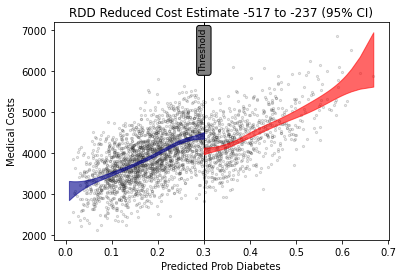

In [6]:
# Getting effect for threshold bump
coef = res.summary2().tables[1]
ci = coef.iloc[1,4:6].astype(int).to_list()

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df['Prob'], df['MedCost'], c='grey',
           edgecolor='k', alpha=0.15, s=5, zorder=1)
ax.axvline(0.3, linestyle='solid', alpha=1.0, 
           color='k',linewidth=1, zorder=2)
ax.fill_between(low['Prob'],low['mean_ci_lower'],
                low['mean_ci_upper'],alpha=0.6,
                zorder=3, color='darkblue')
ax.fill_between(high['Prob'],high['mean_ci_lower'],
                high['mean_ci_upper'],alpha=0.6,
                zorder=3, color='red')
ax.set_xlabel('Predicted Prob Diabetes')
ax.set_ylabel('Medical Costs')
ax.set_title(f'RDD Reduced Cost Estimate {ci[0]} to {ci[1]} (95% CI)')
ax.text(0.3,6500,'Threshold',rotation=90, size=9,
         ha="center", va="center",
         bbox=dict(boxstyle="round", ec='k',fc='grey'))
plt.savefig('RDD.png', dpi=500, bbox_inches='tight')